## required libraries

In [15]:
!pip install -q amplpy yfinance matplotlib

## imports and setup

In [16]:
from amplpy import AMPL, ampl_notebook, Environment
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex"],
    license_uuid=os.getenv("AMPL_LICENSE_UUID"), # or replace with a string with your own
)

AMPL Development Version 20250318 (Darwin-22.6.0, 64-bit)
Demo license with maintenance expiring 20270131.
Using license file "/Users/yhhu/Documents/course/2024/Artificial Intelligence Driven Decision Making/CA/CA2/DDM_code/sp100-optimizer/venv/lib/python3.12/site-packages/ampl_module_base/bin/ampl.lic".



## data retrival
gets the sp100's stocks' adjusted closing price

In [17]:
sp100 = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "AMD", "AMGN", "AMT", "AMZN",
    "AVGO", "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "BRK-B", "C",
    "CAT", "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CRM", "CSCO", "CVS",
    "CVX", "DE", "DHR", "DIS", "DUK", "EMR", "FDX", "GD", "GE", "GILD", "GM",
    "GOOG", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "INTU", "ISRG", "JNJ",
    "JPM", "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ", "MDT",
    "MET", "META", "MMM", "MO", "MRK", "MS", "MSFT", "NEE", "NFLX", "NKE",
    "NOW", "NVDA", "ORCL", "PEP", "PFE", "PG", "PLTR", "PM", "PYPL", "QCOM",
    "RTX", "SBUX", "SCHW", "SO", "SPG", "T", "TGT", "TMO", "TMUS", "TSLA",
    "TXN", "UNH", "UNP", "UPS", "USB", "V", "VZ", "WFC", "WMT", "XOM"
]

# this is where you can adjust the date to make q1, q2, q3 ,q4 q1-q4, etc
closings = yf.download(sp100,group_by='column', start='2024-01-01', end='2024-12-31')['Close']
closings.head()

[*********************100%***********************]  101 of 101 completed


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,184.532089,152.743408,107.138481,341.431366,580.070007,67.074501,138.580002,286.354187,209.915833,149.929993,...,163.363098,528.766113,236.856384,148.922592,41.472164,256.474792,35.250214,47.823631,52.324093,98.106003
2024-01-03,183.150375,153.355072,106.816628,332.573730,571.789978,66.850395,135.320007,289.531738,205.963303,148.470001,...,160.930893,531.403320,235.173096,148.170181,40.376572,255.592987,35.504070,47.193470,52.327377,98.930252
2024-01-04,180.824356,154.310791,108.240593,331.756866,567.049988,66.869888,136.009995,291.919708,206.702011,144.570007,...,158.739975,534.726807,234.550400,147.652893,40.811028,257.207886,35.694466,47.775150,51.821510,98.067657
2024-01-05,180.098694,154.960663,108.065033,331.294281,564.599976,67.240150,138.580002,291.756012,205.569962,145.240005,...,159.348038,526.844482,233.431458,149.280014,41.377720,257.287170,36.446980,48.395607,51.476604,98.364777
2024-01-08,184.452560,154.282104,109.625542,334.965302,580.549988,66.470413,146.179993,299.343597,207.296799,149.100006,...,162.668182,526.001343,234.122269,150.408615,41.519390,260.110779,36.356312,48.395607,51.982471,96.725838


translate to fractional change

In [18]:
day_stock_returns_daily = closings.pct_change().fillna(0)
day_stock_returns_daily.head() # day x stock

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-03,-0.007488,0.004005,-0.003004,-0.025943,-0.014274,-0.003341,-0.023524,0.011097,-0.018829,-0.009738,...,-0.014888,0.004987,-0.007107,-0.005052,-0.026418,-0.003438,0.007202,-0.013177,0.000063,0.008402
2024-01-04,-0.012700,0.006232,0.013331,-0.002456,-0.008290,0.000292,0.005099,0.008248,0.003587,-0.026268,...,-0.013614,0.006254,-0.002648,-0.003491,0.010760,0.006318,0.005363,0.012325,-0.009667,-0.008719
2024-01-05,-0.004013,0.004211,-0.001622,-0.001394,-0.004321,0.005537,0.018896,-0.000561,-0.005477,0.004634,...,0.003831,-0.014741,-0.004771,0.011020,0.013886,0.000308,0.021082,0.012987,-0.006656,0.003030
2024-01-08,0.024175,-0.004379,0.014440,0.011081,0.028250,-0.011448,0.054842,0.026007,0.008400,0.026577,...,0.020836,-0.001600,0.002959,0.007560,0.003424,0.010975,-0.002488,0.000000,0.009827,-0.016662


make benchmark

this assumes the sp100 index is non weighed

In [19]:
day_mean_return = day_stock_returns_daily.mean(axis=1)
day_mean_return.head() # day x mean

Date
2024-01-02    0.000000
2024-01-03   -0.008313
2024-01-04   -0.000929
2024-01-05    0.002937
2024-01-08    0.010035
dtype: float64

definitions and constants

In [20]:
q = 3  # nr of desired stocks

stocks = range(len(sp100)) # map the code to an integer
time_periods = range(len(day_stock_returns_daily)) # map the day to an integer

# data for ampl
stock_day_returns_daily = day_stock_returns_daily.values.T  # stocks x day
day_mean_return_array = day_mean_return.values

In [21]:
# init ampl
ampl = AMPL(Environment())
ampl.setOption('solver', 'gurobi')  # or 'cplex', 'ipopt', etc.

ampl.eval("""
set STOCKS;
set TIME;

param returns{STOCKS, TIME};
param day_mean_return_array{TIME};
param q;

var w{STOCKS} >= 0;  # weights of selected
var y{STOCKS} binary; # selected? bool

minimize tracking_error:
    sum{t in TIME} (sum{s in STOCKS} (w[s] * returns[s,t]) - day_mean_return_array[t])^2; # tracking error function - quadratic!!!!

subject to sum_weights:
    sum{s in STOCKS} w[s] = 1; # weights have to sum up to 1

subject to select_q_stocks:
    sum{s in STOCKS} y[s] = q; # there must be q selected

subject to linking_constraint{s in STOCKS}:
    w[s] <= y[s];  # selection means weight

""")

ampl.set['STOCKS'] = list(stocks)
ampl.set['TIME'] = list(time_periods)
ampl.param['returns'] = {(s, t): stock_day_returns_daily[s][t] for s in stocks for t in time_periods}
ampl.param['day_mean_return_array'] = {t: day_mean_return_array[t] for t in time_periods}
ampl.param['q'] = q

ampl.solve()

Gurobi 12.0.1:Gurobi 12.0.1: optimal solution; objective 0.00420215801
925780 simplex iterations
149291 branching nodes
absmipgap=8.67362e-19, relmipgap=0


display

In [22]:
results = {
    sp100[s]: w for s, w in filter(lambda w: w[1] > 0, ampl.getVariable('w').getValues().to_list())
}

results_2 = {
    s: w for s, w in filter(lambda w: w[1] > 0, ampl.getVariable('w').getValues().to_list())
}

results

{'BRK-B': 0.4964872733738995,
 'LOW': 0.238976795757593,
 'MSFT': 0.2645359308685075}

## evaluation

In [23]:
weights2 = {
    s: w for s, w in filter(lambda w: w[1] > 0, ampl.getVariable('w').getValues().to_list())
}

selected_stocks_idx = weights2.keys()
selected_stocks_name = [sp100[i] for i in selected_stocks_idx]
selected_weights = [weights2[s] for s in selected_stocks_idx]

# apply the portfolio factor in a daily basis to the daily retuns

portfolio_returns = pd.Series(
    [
        sum(stock_day_returns_daily[s][t] * weights2[s] for s in selected_stocks_idx) for t in time_periods
    ],
    index=day_stock_returns_daily.index
)
portfolio_returns

Date
2024-01-02    0.000000
2024-01-03   -0.001289
2024-01-04   -0.007237
2024-01-05    0.003930
2024-01-08    0.013716
                ...   
2024-12-23    0.000104
2024-12-24    0.009943
2024-12-26   -0.001034
2024-12-27   -0.008401
2024-12-30   -0.009783
Length: 251, dtype: float64

## correlation coefficient

In [24]:
correlation = np.corrcoef(portfolio_returns, day_mean_return_array)
correlation

array([[1.        , 0.84836446],
       [0.84836446, 1.        ]])

83% correlation
## tracking error
compare

In [25]:
tracking_error = np.sqrt( # root mean squared error (to get original units)
    np.mean( # mean squared error
        (portfolio_returns - day_mean_return_array)**2 # squared error
    )
)

In [26]:
for si, w in weights2.items():
    print(f"{sp100[si]}: {w:.4f}")

print(f"correlation with sp100: {correlation[0, 1]:.4f}")
print(f"tracking error: {tracking_error:.4f}")

BRK-B: 0.4965
LOW: 0.2390
MSFT: 0.2645
correlation with sp100: 0.8484
tracking error: 0.0041


## plot
side by side cumulative return comparison against the benchmark

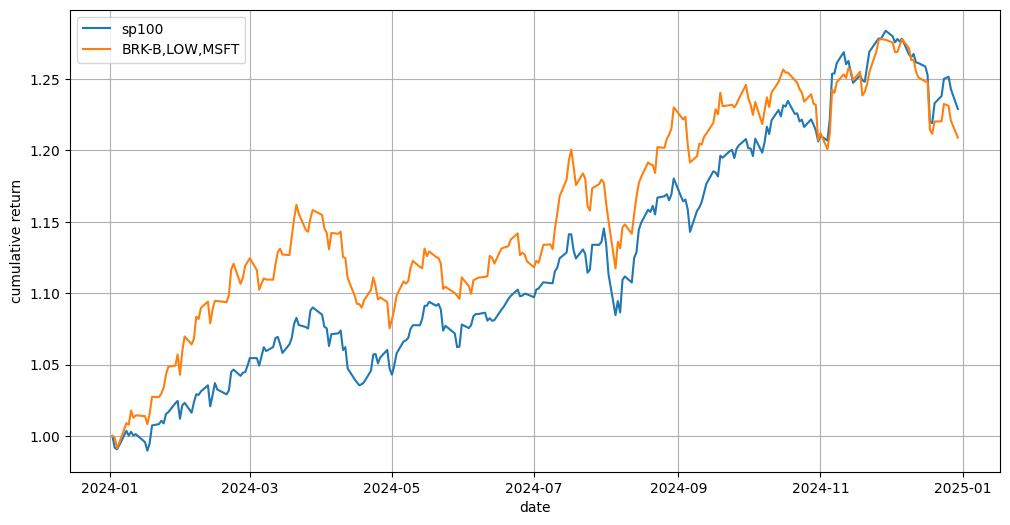

In [27]:
cumulative_index = (1 + day_mean_return).cumprod()
cumulative_portfolio = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_index, label='sp100')
plt.plot(cumulative_portfolio, label=','.join([sp100[s] for s in weights2.keys()]))
plt.xlabel('date')
plt.ylabel('cumulative return')
plt.legend()
plt.grid(True)
plt.show()